<a href="https://colab.research.google.com/github/WellsAr/WellsAr.github.io/blob/main/Structural_Break_LC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [7]:
from google.colab import files

# Open a file upload dialog
uploaded = files.upload()


Saving DeathsGH.csv to DeathsGH.csv


**Exploratory Data Analysis**

In [8]:
## import data

data = pd.read_csv('DeathsGH.csv')

## clean data
data = data.dropna()

## transform data from number of deaths to death rates

mort_rates = []
for year in range(2010, 2021):
    mort_rates.append(data[f'{year}']/data[f'{year}.1'])

## convert mort_rates list into numpy array
mort_rates = np.array(mort_rates)

## convert mort_rates array list into pd dataframe
mort_df = pd.DataFrame(mort_rates)

## renaming rows and columns
mort_df.columns = list(range(40, 84))
mort_df.index = list(range(2010, 2021))


In [9]:
# Compute basic descriptive statistics
data = {
    "Statistic": [
        "Mortality rate",
        "Log mortality"
    ],
    "Mean": [mort_df.values.mean(), np.log(mort_df).values.mean()],
    "Std. Dev.": [mort_df.values.std(), np.log(mort_df).values.std()],
    "Min": [mort_df.values.min(), np.log(mort_df).values.min()],
    "Max": [mort_df.values.max(), np.log(mort_df).values.max()]
}

df_summary = pd.DataFrame(data)
df_summary = df_summary.set_index('Statistic')
df_summary

,Mean,Std. Dev.,Min,Max
Statistic,,,,
Mortality rate,0.022099,0.025662,0.001434,0.118351
Log mortality,-4.511521,1.236801,-6.547455,-2.134097


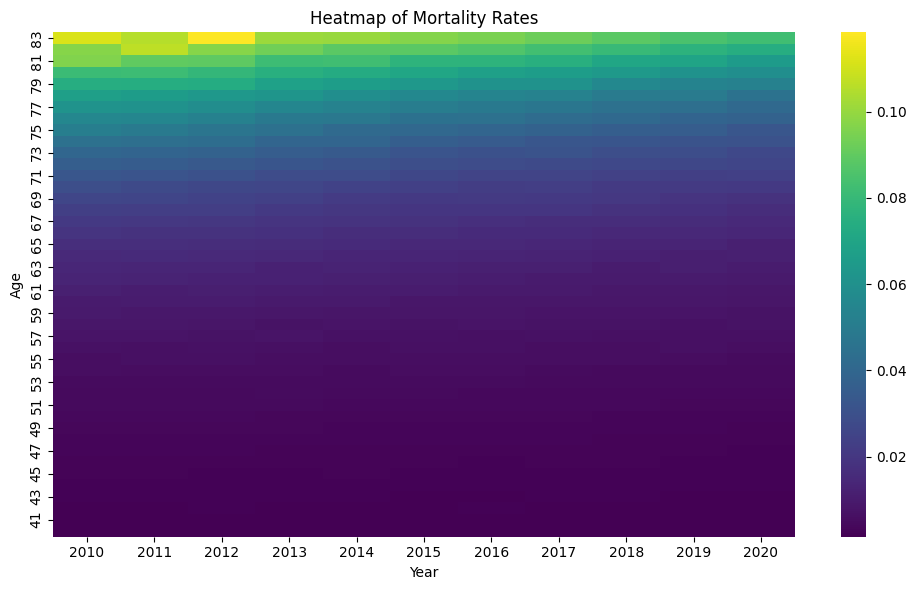

In [10]:
# using heatmap

plt.figure(figsize=(10, 6))
sns.heatmap(mort_df.T.sort_index(ascending=False), cmap="viridis")
plt.title("Heatmap of Mortality Rates")
plt.xlabel("Year")
plt.ylabel("Age")
plt.tight_layout()

# Save the plot as a PNG image
#plt.savefig('heatmap_mortality.png')

plt.show()

# Now download the plot
#files.download('heatmap_mortality.png')


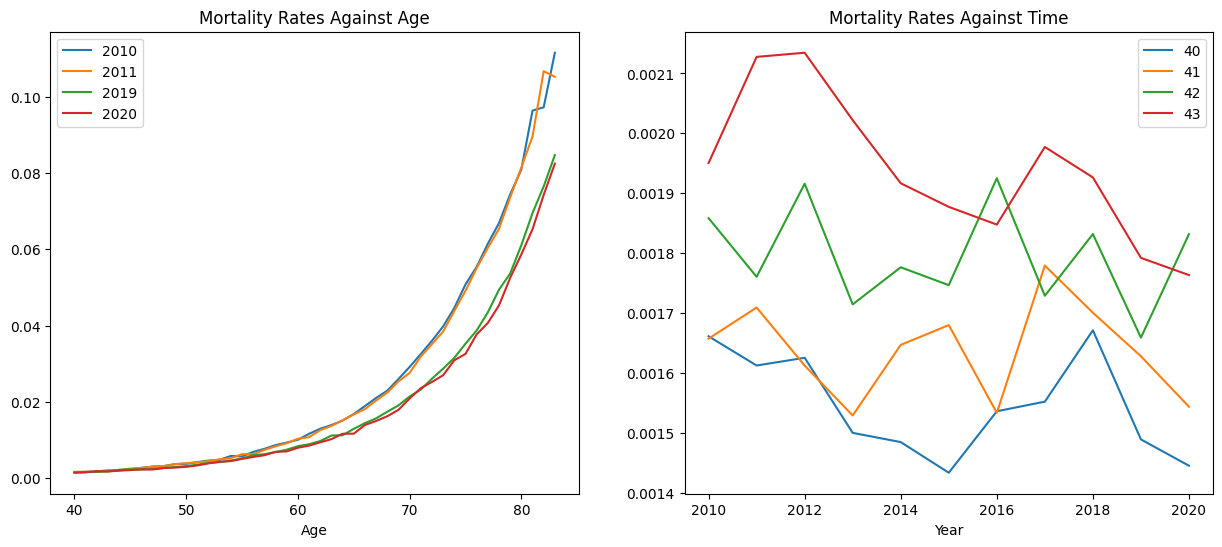

In [11]:
fig, axp = plt.subplots(1, 2, figsize=(15, 6))

axp[0].plot(mort_df.T[[2010, 2011, 2019, 2020]], label=[2010, 2011, 2019, 2020])
axp[0].set_title('Mortality Rates Against Age')
axp[0].set_xlabel('Age')
axp[0].legend()

axp[1].plot(mort_df[[40, 41, 42, 43]], label=[40, 41, 42, 43])
axp[1].set_title('Mortality Rates Against Time')
axp[1].set_xlabel('Year')
axp[1].legend()

# Save the plot as a PNG image
#plt.savefig('mortality_trend_by_age_time.png')

plt.show()

# Now download the plot
#files.download('mortality_trend_by_age_time.png')

**Lee-Carter Model Parameter Estimation**

In [12]:

## Lee-Carter Model

# split data
mort_df_n = mort_df
split_point = np.round(len(mort_df_n)*0.7)

train_df = mort_df_n.iloc[:int(split_point)]
test_df = mort_df_n.iloc[int(split_point):]

## estimating parameters

# conver mortality rates into log mortality rates
log_mort_df = np.log(train_df)

## average log mortality rates
ax = log_mort_df.mean()

## centering log mortality rates
centered_log_mort_rates = log_mort_df - ax
centered_log_mort_rates = centered_log_mort_rates.transpose()

# Singular Value Decomposition (SVD)

U, s, Vt = np.linalg.svd(centered_log_mort_rates, full_matrices=False)

## bx
bx = U[:, 0]

## normalize bx
bx_sum = np.sum(bx)
bx = bx/bx_sum

## extract and normalize kt
kt = s[0] * Vt[0] * bx_sum

## putting ax, bx and kt into dataframe

abx_df = pd.DataFrame([np.array(ax), bx])
abx_df = abx_df.transpose()
abx_df.columns = ['ax', 'bx']
abx_df['Age'] = list(range(40, 84))
abx_df = abx_df.set_index('Age')

kt_df = pd.DataFrame([kt])
kt_df = kt_df.transpose()
kt_df.columns = ['kt']
kt_df['Year'] = list(range(2010, 2018))
kt_df = kt_df.set_index('Year')

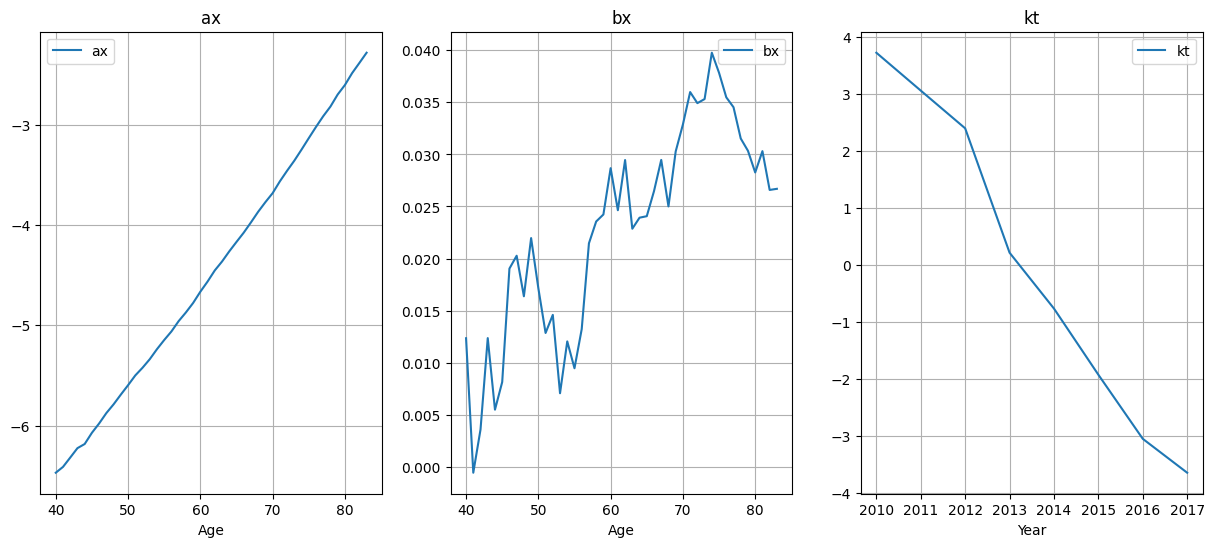

In [13]:
# Plot parameters of the lee carter model

fig, axp = plt.subplots(1, 3, figsize=(15, 6))

axp[0].plot(list(range(40,84)), ax, label='ax')
axp[0].set_title('ax')
axp[0].set_xlabel('Age')
axp[0].legend()
axp[0].grid()

axp[1].plot(list(range(40,84)), bx, label='bx')
axp[1].set_title('bx')
axp[1].set_xlabel('Age')
axp[1].legend()
axp[1].grid()

axp[2].plot(list(range(2010, 2018)), kt, label='kt')
axp[2].set_title('kt')
axp[2].set_xlabel('Year')
axp[2].legend()
axp[2].grid()

# Save the plot as a PNG image
#plt.savefig('ax_bx_kt.png')

plt.show()

# Now download the plot
#files.download('ax_bx_kt.png')


**Model Evaluation on Training Data**

In [14]:
## building the model

def lee_carter_model(ax, bx, kt):
    """returns an array of forecasted mortality rates"""
    s = np.outer(bx, kt)
    forecasted_log_mx = [ax[i] + itm for i,itm in zip(range(40, 84), s)] # ax + bx*kt
    forecasted_mx = np.exp(forecasted_log_mx)
    return forecasted_mx

predicted_mortality = lee_carter_model(ax, bx, kt)

In [15]:
# model evaluation on training
predicted_mortality_train_df = pd.DataFrame(predicted_mortality)
predicted_mortality_train_df.columns = list(range(2010, 2018))
predicted_mortality_train_df['Age'] = list(range(40, 84))
predicted_mortality_train_df = predicted_mortality_train_df.set_index('Age')

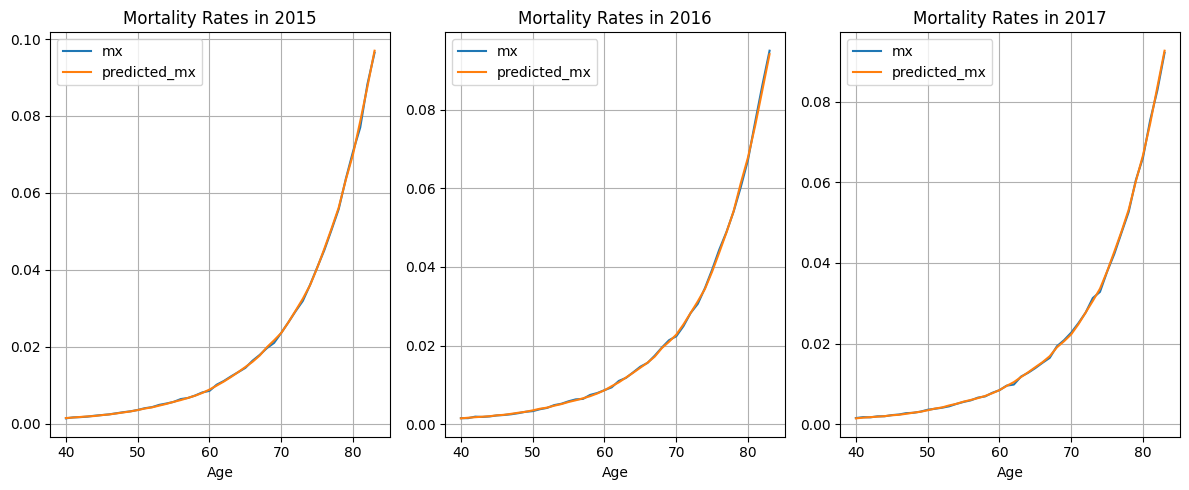

In [16]:
# Plot results on training data
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

# First subplot
axs[0].plot(train_df.T[2015], label='mx')
axs[0].plot(predicted_mortality_train_df[2015], label='predicted_mx')
axs[0].set_title('Mortality Rates in 2015')
axs[0].set_xlabel('Age')
axs[0].grid()
axs[0].legend()

# Second subplot
axs[1].plot(train_df.T[2016], label='mx')
axs[1].plot(predicted_mortality_train_df[2016], label='predicted_mx')
axs[1].set_title('Mortality Rates in 2016')
axs[1].set_xlabel('Age')
axs[1].grid()
axs[1].legend()

# Third subplot
axs[2].plot(train_df.T[2017], label='mx')
axs[2].plot(predicted_mortality_train_df[2017], label='predicted_mx')
axs[2].set_title('Mortality Rates in 2017')
axs[2].set_xlabel('Age')
axs[2].grid()
axs[2].legend()

# Adjust layout
plt.tight_layout()

# Save the plot as a PNG image
#plt.savefig('in_sample_fit.png')

plt.show()

# Now download the plot
#files.download('in_sample_fit.png')


**CUSUM Break Detection**

In [32]:
kt_break = np.diff(kt)

n = len(kt_break)

# Sample std deviation (ddof=1)
sigma_hat = kt_break.std(ddof=1)
total_sum = kt_break.sum()

v_values = np.linspace(0.01, 0.49, 5)

all_results = []

for v in v_values:
    cusum_w_values = []
    partial_w_sums = []
    weights = []
    adjusted_w_terms = []

    for k in range(1, n):
        partial_w_sum = kt_break[:k].sum()
        adjusted_w_term = partial_w_sum - (k/n) * total_sum
        cusum_w_ = abs(adjusted_w_term) / (sigma_hat * np.sqrt(n))

        # weight with exponent v
        weight = ((n**2) / (k*(n - k)))**v
        cusum_w_k = weight * cusum_w_

        partial_w_sums.append(partial_w_sum)
        weights.append(weight)
        adjusted_w_terms.append(adjusted_w_term)
        cusum_w_values.append(cusum_w_k)

    # Store into a DataFrame for this v
    df_tmp = pd.DataFrame({
        "v": v,
        "k": np.arange(1, n),
        "partial_sum": partial_w_sums,
        "weights": weights,
        "adjusted_term": adjusted_w_terms,
        "CUSUM(k)": cusum_w_values
    })

    all_results.append(df_tmp)

# Combine results for all v
df_cusum_w_all = pd.concat(all_results, ignore_index=True)

print(df_cusum_w_all.to_string(index=False))

   v  k  partial_sum  weights  adjusted_term  CUSUM(k)
0.01  1    -0.665383 1.021223       0.388765  0.272817
0.01  2    -1.328359 1.016019       0.779936  0.544534
0.01  3    -3.513242 1.014169      -0.350799  0.244474
0.01  4    -4.494918 1.014169      -0.278327  0.193968
0.01  5    -5.657408 1.016019      -0.386669  0.269964
0.01  6    -6.783498 1.021223      -0.458613  0.321833
0.13  1    -0.665383 1.313911       0.388765  0.351008
0.13  2    -1.328359 1.229491       0.779936  0.658943
0.13  3    -3.513242 1.200693      -0.350799  0.289437
0.13  4    -4.494918 1.200693      -0.278327  0.229642
0.13  5    -5.657408 1.229491      -0.386669  0.326685
0.13  6    -6.783498 1.313911      -0.458613  0.414071
0.25  1    -0.665383 1.690485       0.388765  0.451608
0.25  2    -1.328359 1.487815       0.779936  0.797392
0.25  3    -3.513242 1.421522      -0.350799  0.342670
0.25  4    -4.494918 1.421522      -0.278327  0.271877
0.25  5    -5.657408 1.487815      -0.386669  0.395323
0.25  6   

In [33]:
# Argmax of CUSUM(k) for each v
argmax_df = (
    df_cusum_w_all
    .loc[df_cusum_w_all.groupby("v")["CUSUM(k)"].idxmax()]
    .sort_values("v")
    .reset_index(drop=True)
)

argmax_df

,v,k,partial_sum,weights,adjusted_term,CUSUM(k)
0,0.01,2,-1.328359,1.016019,0.779936,0.544534
1,0.13,2,-1.328359,1.229491,0.779936,0.658943
2,0.25,2,-1.328359,1.487815,0.779936,0.797392
3,0.37,2,-1.328359,1.800415,0.779936,0.964929
4,0.49,2,-1.328359,2.178693,0.779936,1.167666


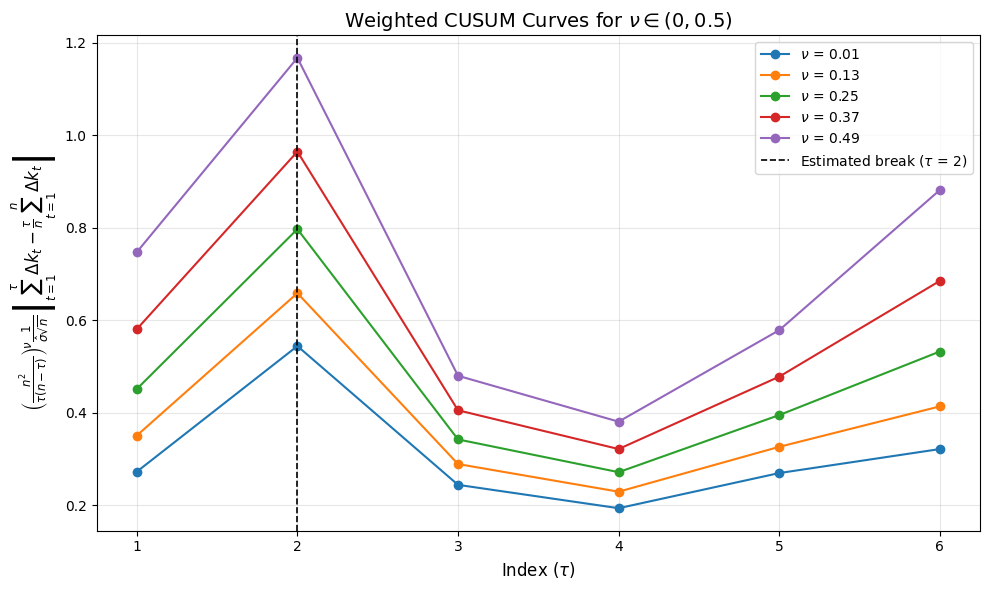

In [19]:
plt.figure(figsize=(10, 6))

for v, df_v in df_cusum_w_all.groupby("v"):
    plt.plot(
        df_v["k"],
        df_v["CUSUM(k)"],
        marker="o",
        label=fr"$\nu$ = {v:.2f}"
    )

# Vertical dashed line at estimated break
k = int(argmax_df['k'][0])
plt.axvline(
    x=k,
    color="black",
    linestyle="--",
    linewidth=1.2,
    label=fr"Estimated break ($\tau$ = {k})"
)

plt.xlabel(r"Index ($\tau$)", fontsize=12)
plt.ylabel(
    r"$\left(\frac{n^2}{\tau(n-\tau)}\right)^{\!\nu}"
    r"\frac{1}{\hat{\sigma}\sqrt{n}}"
    r"\left| \sum_{t=1}^{\tau} \Delta k_t - "
    r"\frac{\tau}{n}\sum_{t=1}^{n}\Delta k_t \right|$",
    fontsize=12
)
plt.title(r"Weighted CUSUM Curves for $\nu \in (0, 0.5)$", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


**Forecasting**

In [20]:
## Forecasting using random walk

def forecast_random_walk_with_drift(kt, mean, var, steps_t, steps):
    """returns an array of forecasted kt"""
    drift = np.mean(np.diff(kt))

    forecast_ = [kt[-1] + drift]
    for _ in range(1, steps):
        forecast_.append(forecast_[-1] + drift)

    return np.array(forecast_)

In [21]:
### Forecasting kt using RW with Drift

kt_forecast_ = forecast_random_walk_with_drift(kt, 0, 1, steps_t=len(kt), steps=3)

In [22]:
## predictions on test data before applying cusum break

predicted_mortality_test = lee_carter_model(ax, bx, kt_forecast_)

predicted_mortality_test_df = pd.DataFrame(predicted_mortality_test)
predicted_mortality_test_df.columns = list(range(2018, 2021))
predicted_mortality_test_df['Age'] = list(range(40, 84))
predicted_mortality_test_df = predicted_mortality_test_df.set_index('Age')

**Incorporating Break Point for Forecasting**

In [23]:
kt_forecast_b_ = forecast_random_walk_with_drift(kt[-6:], 0, 1, steps_t=len(kt), steps=3)  # kt[-6:] is the kt values from the break point at k = 2
kt_pl = np.insert(kt, 8, kt_forecast_b_[0])

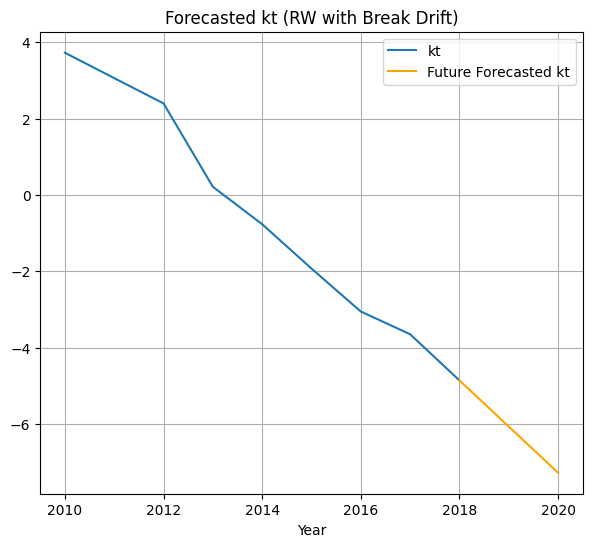

In [24]:
# plot kt forecasts

plt.figure(figsize=(7, 6))

plt.plot(list(range(2010, 2019)), kt_pl, label='kt')
plt.plot(list(range(2018, 2021)), kt_forecast_b_, label='Future Forecasted kt', color='orange')
plt.title('Forecasted kt (RW with Break Drift)')
plt.xlabel('Year')
plt.grid()
plt.legend()

# Save the plot as a PNG image
#plt.savefig('kt_forecast_brk.png')

plt.show()

# Now download the plot
#files.download('kt_forecast_brk.png')


**Evaluation on Test Data**

In [25]:
## predictions on test data

predicted_mortality_test_b = lee_carter_model(ax, bx, kt_forecast_b_)

# model evaluation on test data
predicted_mortality_test_b_df = pd.DataFrame(predicted_mortality_test_b)
predicted_mortality_test_b_df.columns = list(range(2018, 2021))
predicted_mortality_test_b_df['Age'] = list(range(40, 84))
predicted_mortality_test_b_df = predicted_mortality_test_b_df.set_index('Age')

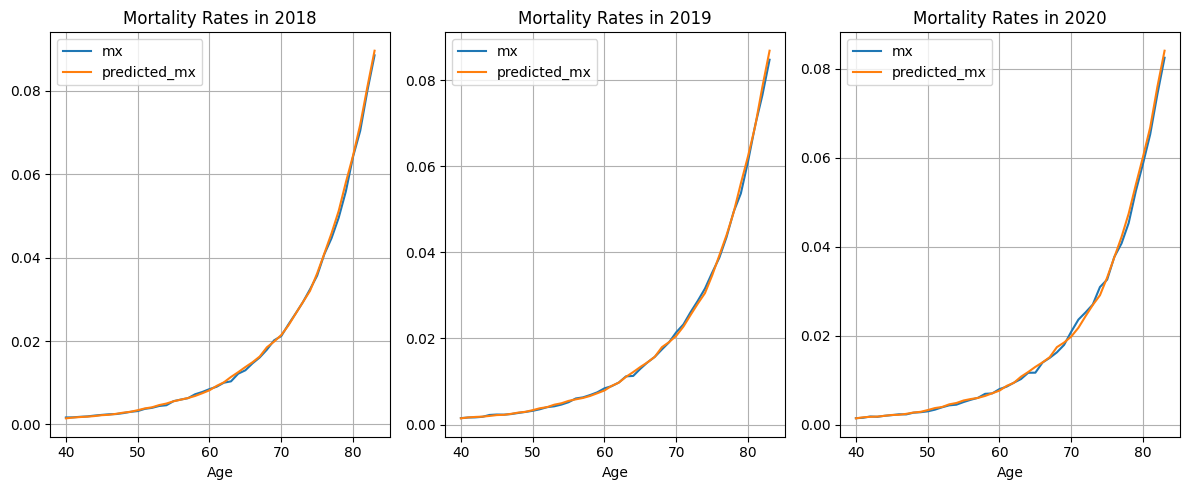

In [26]:
# Plot results
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

# First subplot
axs[0].plot(test_df.T[2018], label='mx')
axs[0].plot(predicted_mortality_test_b_df[2018], label='predicted_mx')
axs[0].set_title('Mortality Rates in 2018')
axs[0].set_xlabel('Age')
axs[0].grid()
axs[0].legend()

# Second subplot
axs[1].plot(test_df.T[2019], label='mx')
axs[1].plot(predicted_mortality_test_b_df[2019], label='predicted_mx')
axs[1].set_title('Mortality Rates in 2019')
axs[1].set_xlabel('Age')
axs[1].grid()
axs[1].legend()

# Third subplot
axs[2].plot(test_df.T[2020], label='mx')
axs[2].plot(predicted_mortality_test_b_df[2020], label='predicted_mx')
axs[2].set_title('Mortality Rates in 2020')
axs[2].set_xlabel('Age')
axs[2].grid()
axs[2].legend()

# Adjust layout
plt.tight_layout()
# Save the plot as a PNG image
#plt.savefig('out_sample_fit_brk.png')

plt.show()

# Now download the plot
#files.download('out_sample_fit_brk.png')


**Model Performance**

In [27]:
## Metrics for standard LC model

#  MSE
mse = mean_squared_error(test_df, predicted_mortality_test_df.T)

#  RMSE
rmse = np.sqrt(mse)

#  MAE
mae = mean_absolute_error(test_df, predicted_mortality_test_df.T)

#  MAPE
mape = np.mean(
    np.abs((test_df.values - predicted_mortality_test_df.T.values) / test_df.values)
) * 100

In [28]:
## Metrics for Structural-Break LC model

#  MSE
mse_b = mean_squared_error(test_df, predicted_mortality_test_b_df.T)

#  RMSE
rmse_b = np.sqrt(mse_b)

#  MAE
mae_b = mean_absolute_error(test_df, predicted_mortality_test_b_df.T)

#  MAPE
mape_b = np.mean(
    np.abs((test_df.values - predicted_mortality_test_b_df.T.values) / test_df.values)
) * 100

In [29]:
metric_both = {"Standard LC": [mse, rmse, mae, mape],
               "Structural-Break LC": [mse_b, rmse_b, mae_b, mape_b]}
metric_both = pd.DataFrame(metric_both)
metric_both.index = ["MSE", "RMSE", "MAE", "MAPE"]
metric_both

,Standard LC,Structural-Break LC
MSE,8.374136e-07,5.300290e-07
RMSE,9.151030e-04,7.280309e-04
MAE,5.588956e-04,4.620698e-04
MAPE,3.582255e+00,3.298566e+00
